In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import Sequential
sns.set()
from tensorflow.keras import layers,losses

In [3]:
df = pd.read_csv('ecg.csv', header=None)
raw_data = df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [4]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]

In [5]:
pd.Series(labels).value_counts()

1.0    2919
0.0    2079
Name: count, dtype: int64

In [6]:
train_data, test_data, train_labels,test_labels = train_test_split(data, labels, test_size = 0.2, random_state=21)

In [7]:
min = np.min(train_data)
max = np.max(train_data)

In [8]:
train_data = (train_data - min) / (max - min)
test_data = (test_data - min) / (max - min)

In [9]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anamalous_train_data = train_data[~train_labels]
anamalous_test_data = test_data[~test_labels]

In [10]:
~train_labels

array([False, False, False, ..., False, False, False])

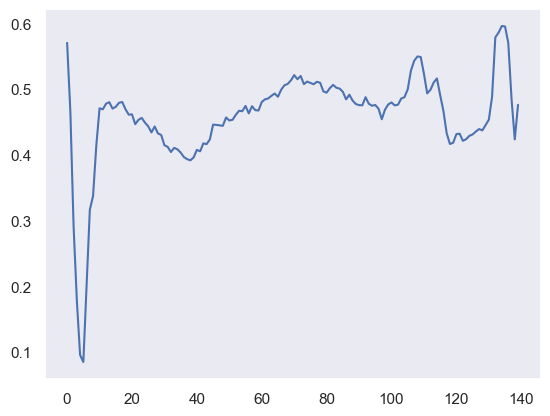

Text(0.5, 1.0, 'A Normal ECG')

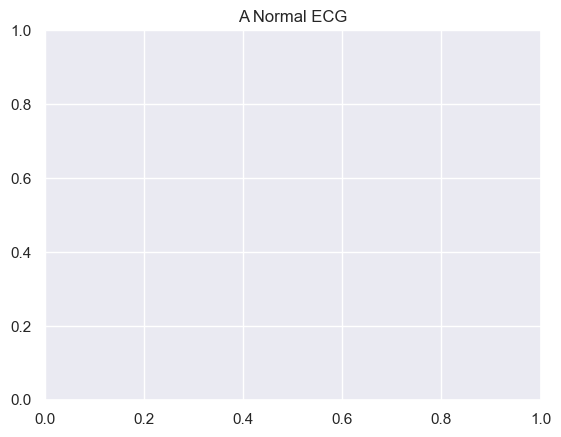

In [11]:
plt.grid()
plt.plot(np.arange(140),normal_train_data[0])
plt.show()
plt.title('A Normal ECG')

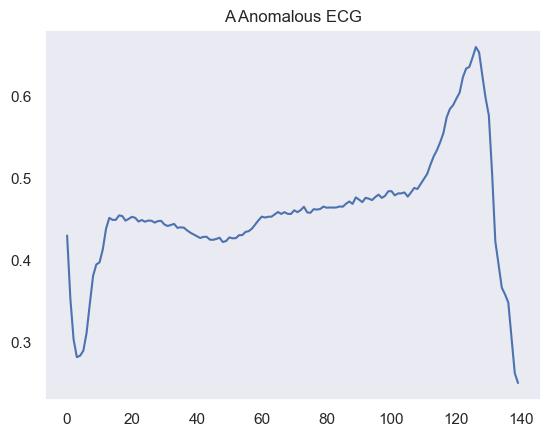

In [12]:
plt.grid()
plt.plot(np.arange(140),anamalous_train_data[0])
plt.title('A Anomalous ECG')
plt.show()

In [13]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector,self).__init__()
        self.encoder = Sequential([
            layers.Dense(16,activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(8,activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16,activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(140,activation='sigmoid')
        ])
    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [14]:
autoencoder.compile(optimizer = 'adam' , loss = 'mae')

In [15]:
history = autoencoder.fit(normal_train_data , normal_train_data ,
                          epochs = 20 ,
                          batch_size = 512 ,
                          validation_data=(normal_test_data , normal_test_data),
                          shuffle = True)

Epoch 1/20
5/5 [==============================] - 2s 91ms/step - loss: 0.0585 - val_loss: 0.0571
Epoch 2/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0566 - val_loss: 0.0555
Epoch 3/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0549 - val_loss: 0.0535
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0529 - val_loss: 0.0511
Epoch 5/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0505 - val_loss: 0.0481
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0479 - val_loss: 0.0449
Epoch 7/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0451 - val_loss: 0.0418
Epoch 8/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0423 - val_loss: 0.0389
Epoch 9/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0399 - val_loss: 0.0362
Epoch 10/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0377 - val_loss: 0.0339
Epoch 11/20
5/5 [============

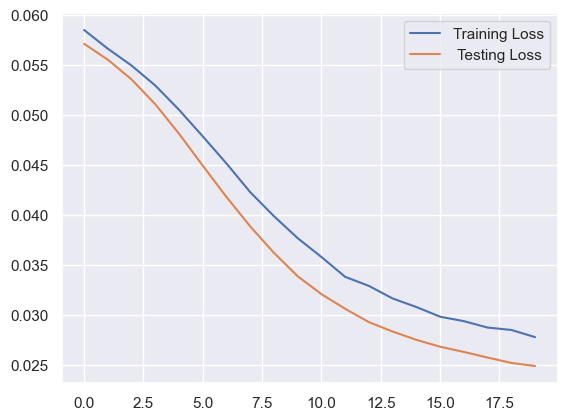

In [16]:
plt.plot(history .history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'],label=' Testing Loss')
plt.legend()

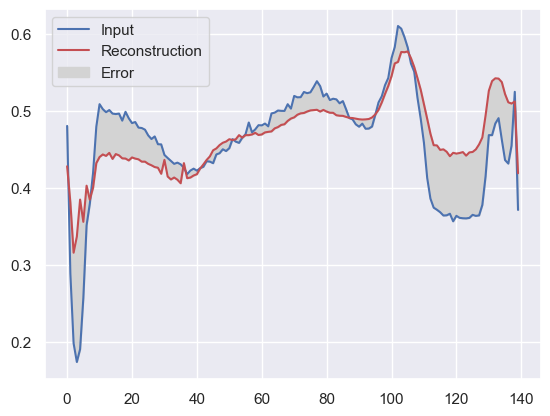

In [17]:
encoded_image = autoencoder.encoder(normal_train_data).numpy()
decoded_image = autoencoder.decoder(encoded_image).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_image[0],'r')
plt.fill_between(np.arange(140),decoded_image[0],normal_test_data[0],color='lightgray')
plt.legend(labels=['Input',"Reconstruction" , "Error"])
plt.show()

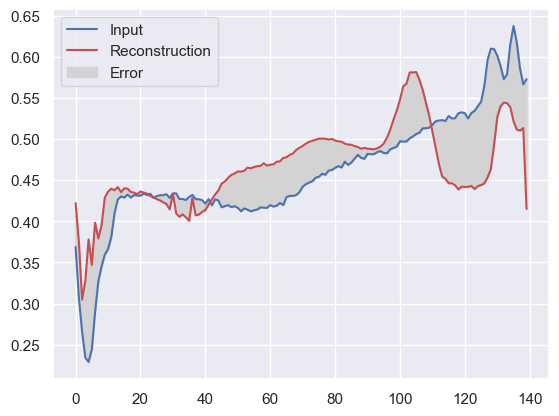

In [18]:
encoded_image = autoencoder.encoder(anamalous_test_data).numpy()
decoded_image = autoencoder.decoder(encoded_image).numpy()

plt.plot(anamalous_test_data[0],'b')
plt.plot(decoded_image[0],'r')
plt.fill_between(np.arange(140),decoded_image[0],anamalous_test_data[0],color='lightgray')
plt.legend(labels=['Input',"Reconstruction" , "Error"])
plt.show()

74/74 [==============================] - 0s 3ms/step


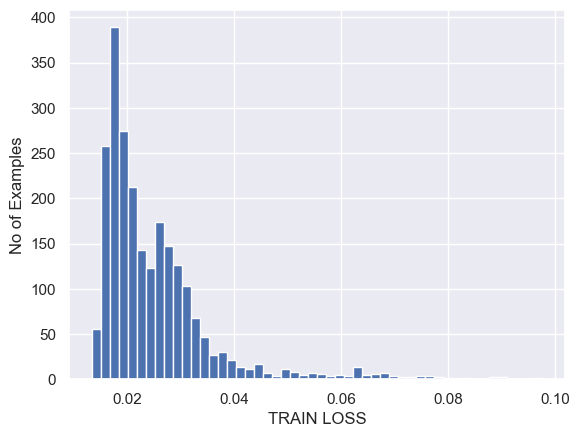

In [19]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions,normal_train_data)

plt.hist(train_loss[None,:],bins=50)
plt.xlabel('TRAIN LOSS')
plt.ylabel("No of Examples")
plt.show()

In [20]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold : " , threshold)

Threshold :  0.035936888832837965


14/14 [==============================] - 0s 4ms/step


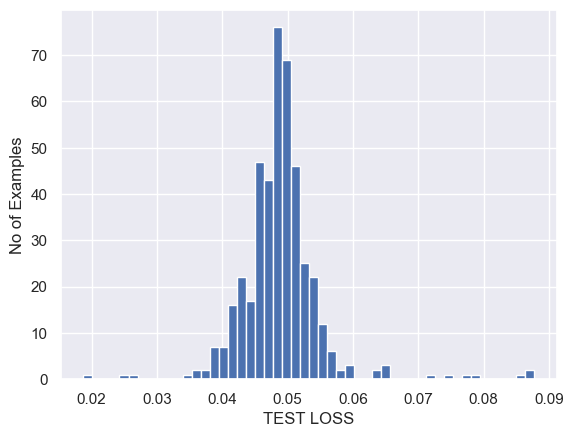

In [21]:
reconstructions = autoencoder.predict(anamalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions,anamalous_test_data)

plt.hist(test_loss[None,:],bins=50)
plt.xlabel('TEST LOSS')
plt.ylabel("No of Examples")
plt.show()

In [22]:
def predict(model,data,threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions,data)
  return tf.math.less(loss,threshold)

def print_stats(predictions,labels):
    print("Accuracy = {}" ,format(accuracy_score(labels,preds)))
    print("Precision = {}" ,format(precision_score(labels,preds)))
    print("Recall = {}" ,format(recall_score(labels,preds)))

In [23]:
preds = predict(autoencoder , test_data , threshold)
print_stats(preds,test_labels)

Accuracy = {} 0.942
Precision = {} 0.9883268482490273
Recall = {} 0.9071428571428571
